# Das Auflösungsvermögen von ESI

## Allgemeine Berechnungen

Dieser Abschnitt enthält Berechnungen, die nicht variieren sollten.


$$v = \sqrt{\frac{2\cdot E}{m_e}}$$

$$v_{rel} = c \cdot \sqrt{1 - \left(\frac{1}{1+\frac{E}{E_0}}\right)^2} = c \cdot \sqrt{1 - \left(\frac{1}{1+\frac{E}{m_e\cdot c^2}}\right)^2}$$

$$\lambda = \frac{h}{\sqrt{2 \cdot m_e \cdot E}}$$

$$\lambda_{rel} = \frac{h}{\sqrt{E \left( 2 \cdot m_e + \frac{E}{c^2}\right)}}$$

$$\alpha(d) = \sin^{-1}\left(\frac{d}{2\cdot f}\right)$$

$$d(\alpha) = 2\cdot f\cdot\sin\alpha$$

In [1]:
import math
from scipy.constants import e, m_e, c, h

def v(energy):
    '''returns the speed of an electron that has the given kinetic energy (in eV).
    This is the non relativistic variant.
    '''
    return math.sqrt(2 * energy * e / m_e)
    
assert round(v(200000), -3) == 265241000

def v_rel(energy):
    '''returns the speed of an electron that has the given kinetic energy (in eV).
    This is the relativistic variant.
    '''
    return c * math.sqrt(1 - (1 / (1 + energy * e / (m_e * c**2)))**2)
    
assert round(v_rel(200000), -3) == 208450000

def wavelength(energy):
    '''returns the wavelength of an electron that has the given kinetic energy (in eV).
    This is the non relativistic variant.
    '''
    return h / math.sqrt(2 * m_e * energy * e)

assert round(wavelength(200000), 18) == 2.742372e-12

def wavelength_rel(energy):
    '''returns the wavelength of an electron that has the given kinetic energy (in eV).
    This is the relativistic variant.
    '''
    return h / math.sqrt(energy * e * (2 * m_e + energy * e / c**2))

assert round(wavelength_rel(200000), 18) == 2.507934e-12

def diameter_to_angle(diameter, focal_length):
    '''returns the collection angle (in rad) for the given parameters of an aperture in the focal plane.
    diameter in m
    focal_length in m
    '''
    return math.asin(diameter / 2 / focal_length)

def angle_to_diameter(angle, focal_length):
    '''returns the aperture diameter for the given parameters of an aperture in the focal plane.
    collection angle in rad
    focal_length in m
    '''
    return 2 * math.sin(angle) * focal_length
    
assert round(diameter_to_angle(20e-6, 1.72e-3), 6) == 0.005814

In [2]:
class RessCalc:
    '''A base class that contains corresponding calculations
    '''
    
    def __init__(self,
                 energy=200000,
                 focal_length=1.72*1e-3,
                 Cs=1.2e-3,
                 Cc=1.2e-3,
                 delta_E=0.7,
                 diameter=20*1e-6
                ):
        '''Create an instance of this class with the properties of a TEM that do not change during operation.
        '''
        self.energy = energy
        self.focal_length = focal_length
        self.Cs = Cs
        self.Cc = Cc
        self.delta_E = delta_E
        self.diameter = diameter
        
    def delta_s(self, diameter):
        '''returns the radius of the error disc created by the spherical aberrtion.
        '''
        return self.Cs * diameter_to_angle(diameter, self.focal_length)**3
        
    def delta_c(self, diameter=None, delta_E=None):
        '''returns the radius of the error disc created by the chromatic aberrtion.
        '''
        if not diameter:
            diameter = self.diameter
        if not delta_E:
            delta_E = self.delta_E
        return diameter_to_angle(diameter, self.focal_length) * self.Cc * delta_E / self.energy
        
    def delta_b(self, diameter):
        '''returns the radius of the error disc created by the diffraction limit.'''
        return 0.61 * wavelength_rel(self.energy) / diameter_to_angle(diameter, self.focal_length)

## Jürgen Thomas und Thomas Gemming (Buch)

Das Auflösungsvermögen wird in Abschnitt 2.4 behandelt. Außerdem zeigt Abschnitt 10.5 wie man das minimale $\delta$ bestimmen kann.
$\delta_b$ und $\delta_s$ sind die Radien der Fehlerscheibchen, die aus dem Öffnungfehler (spherische Aberration) und dem Beugungsfehler resultieren. Außerdem wird wegen der sehr kleinen Winkel die Näherung $\sin\alpha\approx\alpha$ verwendet.

$$\delta_B = \frac{0,61\cdot\lambda}{\alpha}$$

$$\delta_S = C_S\cdot\alpha^3$$

$$\delta_T = \sqrt{\delta_B^2 + \delta_S^2}$$

$$\alpha_{opt} = 0,77\cdot\left(\frac{\lambda_{rel}}{C_s}\right)^{\frac{1}{4}}$$

$$\delta_C = \alpha \cdot C_c \cdot \frac{\delta E}{E_0}$$

In [3]:
class ThomasAndGemming(RessCalc):
    '''A class to calculate the resolution limit of a TEM
    based on the equations in the TEM book by Jürgen Thomas and Thomas Gemming.
    '''
        
    def __init__(self,
                 energy=200000,
                 focal_length=1.72*1e-3,
                 Cs=1.2e-3,
                 Cc=1.2e-3,
                 delta_E=0.7,
                 diameter=20*1e-6
                ):
        '''Create an instance of this class with the properties of a TEM that do not change during operation.
        '''
        self.energy = energy
        self.focal_length = focal_length
        self.Cs = Cs
        self.Cc = Cc
        self.delta_E = delta_E
        self.diameter = diameter
    
    def delta_total(self, diameter):
        return math.sqrt(self.delta_s(diameter)**2 + self.delta_b(diameter)**2)
            
    def delta_total_c(self, diameter):
        return math.sqrt(self.delta_s(diameter)**2 + self.delta_b(diameter)**2 + self.delta_c(diameter)**2)
    
    def opt_angle(self):
        return 0.77 * math.pow(wavelength_rel(self.energy) / self.Cs, 0.25)
        

resCalcTG = ThomasAndGemming()
aperture = 20e-6
print("--- Auflösungsvermögen für eine Objektivblende mit 20 µm Durchmesser ---")
print("\tBeugungsfehler: %.3f nm" % (resCalcTG.delta_b(aperture)*1e9))
print("\tÖffnungfehler: %.3f nm" % (resCalcTG.delta_s(aperture)*1e9))
print("\tAuflösungsvermögen: %.3f nm" % (resCalcTG.delta_total(aperture)*1e9))
print("\tAuflösungsvermögen mit C_C: %.3f nm" % (resCalcTG.delta_total_c(aperture)*1e9))

opt_aperture = angle_to_diameter(resCalcTG.opt_angle(), resCalcTG.focal_length)
print("\nOptimaler Blendendurchmesser: %.1f µm" % (opt_aperture*1e6))
print("\tAuflösungsvermögen: %.3f nm" % (resCalcTG.delta_total(opt_aperture)*1e9))

print("\n--- Auflösungsvermögen bei ESI ---")
slit = 30
resCalcTG.delta_E = slit
print("\tFarbfehler bei %d eV Spaltbreite: %.3f nm" % (slit, resCalcTG.delta_c(opt_aperture)*1e9))
print("\tAuflösungsvermögen: %.3f nm" % (resCalcTG.delta_total_c(opt_aperture)*1e9))

--- Auflösungsvermögen für eine Objektivblende mit 20 µm Durchmesser ---
	Beugungsfehler: 0.263 nm
	Öffnungfehler: 0.236 nm
	Auflösungsvermögen: 0.353 nm
	Auflösungsvermögen mit C_C: 0.354 nm

Optimaler Blendendurchmesser: 17.9 µm
	Auflösungsvermögen: 0.339 nm

--- Auflösungsvermögen bei ESI ---
	Farbfehler bei 30 eV Spaltbreite: 0.937 nm
	Auflösungsvermögen: 0.997 nm


C_s: 1.2 mm
Beschleunigungsspannung: 200 keV
Wellenlänge: 2.508 pm


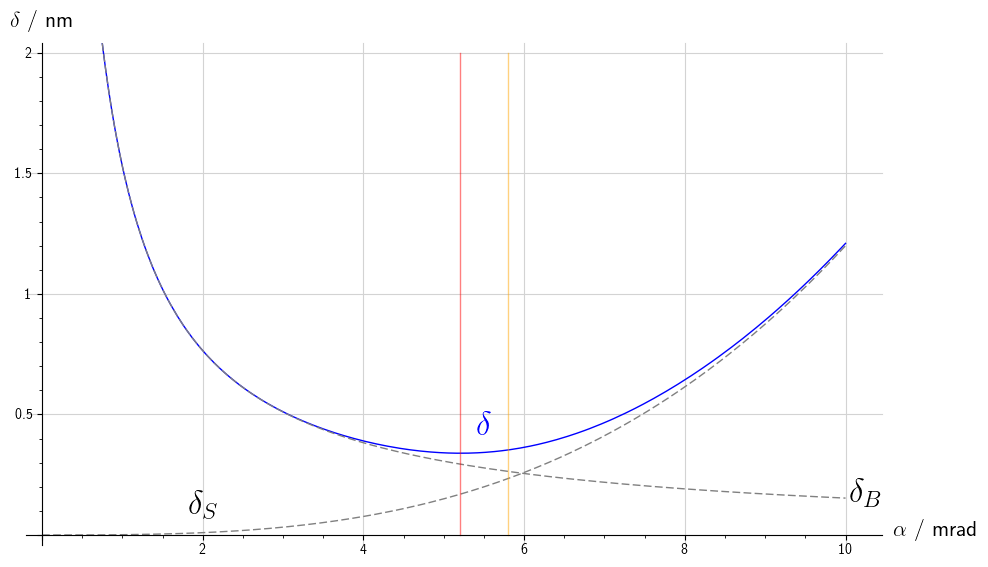

In [4]:
def prepare_to_plot(func):    
    def new_func(angle):
        diameter = angle_to_diameter(angle * 1e-3, resCalcTG.focal_length)
        return func(diameter) * 1e9
    return new_func

import matplotlib.pyplot as plt

p = plot(prepare_to_plot(resCalcTG.delta_total),
         (0, 10),
         ymax=2,
         axes_labels=(r'$\alpha$ / mrad', r'$\delta$ / nm')
        ) + \
    plot(prepare_to_plot(resCalcTG.delta_b), (0, 10), linestyle='--', color='grey') + \
    plot(prepare_to_plot(resCalcTG.delta_s), (0, 10), linestyle='--', color='grey') + \
    text("$\delta$", (5.5, 0.45), fontsize=24, color='blue') + \
    text("$\delta_S$", (2, 0.1), fontsize=24, color='black') + \
    text("$\delta_B$", (10.25, 0.15), fontsize=24, color='black') + \
    line([(5.2,0), (5.2,2)], color='red', alpha=0.5) + \
    line([(5.8,0), (5.8,2)], color='orange', alpha=0.5)

print('C_s: %.1f mm\nBeschleunigungsspannung: %d keV\nWellenlänge: %.3f pm' % (resCalcTG.Cs*1e3,
                                                                               resCalcTG.energy*1e-3,
                                                                               wavelength_rel(resCalcTG.energy)*1e12
                                                                              ))
p.show(figsize=10, aspect_ratio=3)
p.save('Bilder/delta_TG.pdf', figsize=10, aspect_ratio=3)

Energiebreite: 0.7 eV
Farbfehler bei 5.8 mrad: 0.024 nm
Auflösung bei 5.8 mrad: 0.354 nm


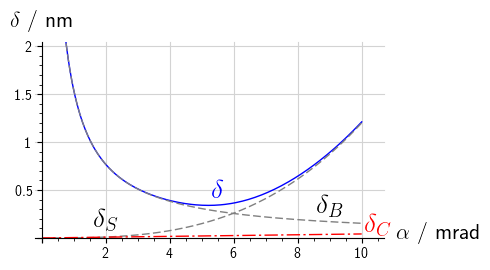

In [5]:
resCalcTG.delta_E = 0.7
print('Energiebreite: %.1f eV' % (resCalcTG.delta_E))
print('Farbfehler bei %.1f mrad: %.3f nm' % (diameter_to_angle(20*1e-6, resCalcTG.focal_length)*1e3,
                                             resCalcTG.delta_c(20*1e-6)*1e9
                                            ))
print('Auflösung bei %.1f mrad: %.3f nm' % (diameter_to_angle(20*1e-6, resCalcTG.focal_length)*1e3,
                                            resCalcTG.delta_total_c(20*1e-6)*1e9
                                           ))

p2 = plot(prepare_to_plot(resCalcTG.delta_total_c),
          (0, 10),
          ymax=2,
          axes_labels=(r'$\alpha$ / mrad', r'$\delta$ / nm')
         ) + \
    plot(prepare_to_plot(resCalcTG.delta_b), (0, 10), linestyle='--', color='grey') + \
    plot(prepare_to_plot(resCalcTG.delta_s), (0, 10), linestyle='--', color='grey') + \
    plot(prepare_to_plot(resCalcTG.delta_c), (0.01, 10), linestyle='-.', color='red') + \
    text("$\delta$", (5.5, 0.5), fontsize=20, color='blue') + \
    text("$\delta_S$", (2, 0.15), fontsize=20, color='black') + \
    text("$\delta_B$", (9, 0.3), fontsize=20, color='black') + \
    text("$\delta_C$", (10.5, 0.1), fontsize=20, color='red')
    
p2.show(figsize=5, aspect_ratio=3)
p2.save('Bilder/delta_TG_0,7eV.pdf', figsize=5, aspect_ratio=3)

Energiebreite: 20.0 eV
Farbfehler bei 5.8 mrad: 0.698 nm
Auflösung bei 5.8 mrad: 0.782 nm


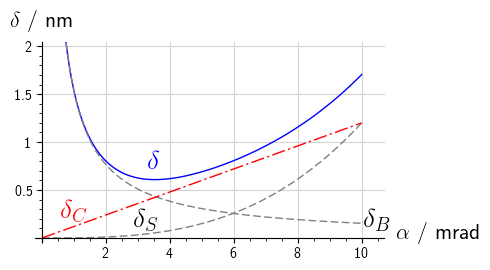

In [6]:
resCalcTG.delta_E = 20
print('Energiebreite: %.1f eV' % (resCalcTG.delta_E))
print('Farbfehler bei %.1f mrad: %.3f nm' % (diameter_to_angle(20*1e-6, resCalcTG.focal_length)*1e3,
                                             resCalcTG.delta_c(20*1e-6)*1e9
                                            ))
print('Auflösung bei %.1f mrad: %.3f nm' % (diameter_to_angle(20*1e-6, resCalcTG.focal_length)*1e3,
                                            resCalcTG.delta_total_c(20*1e-6)*1e9
                                           ))

p3 = plot(prepare_to_plot(resCalcTG.delta_total_c),
          (0, 10),
          ymax=2,
          axes_labels=(r'$\alpha$ / mrad', r'$\delta$ / nm')
         ) + \
    plot(prepare_to_plot(resCalcTG.delta_b), (0, 10), linestyle='--', color='grey') + \
    plot(prepare_to_plot(resCalcTG.delta_s), (0, 10), linestyle='--', color='grey') + \
    plot(prepare_to_plot(resCalcTG.delta_c), (0.01, 10), linestyle='-.', color='red') + \
    text("$\delta$", (3.5, 0.8), fontsize=20, color='blue') + \
    text("$\delta_S$", (3.25, 0.15), fontsize=20, color='black') + \
    text("$\delta_B$", (10.5, 0.15), fontsize=20, color='black') + \
    text("$\delta_C$", (1, 0.25), fontsize=20, color='red')
    
p3.show(figsize=5, aspect_ratio=3)
p3.save('Bilder/delta_TG_20eV.pdf', figsize=5, aspect_ratio=3)

### Optimierung mit chromatischer Aberration

Unter Berücksichtigung von spherischer Aberrration und Beugungslimit wurde der optimale Winkel zu 5,8 mrad bestimmt. Im folgenden soll außerdem die chromatische Aberration berücksichtigt werden.

In [7]:
var('lambda_rel alpha C_s dE E C_c')
delta_s = C_s * alpha**3
delta_b = 6 / 10 * lambda_rel / alpha
delta_c = alpha * C_c * dE / E
delta = sqrt((delta_s)**2 + (delta_b)**2 + (delta_c)**2)

show(derivative(delta, alpha))

1/25*(75*C_s^2*alpha^5 + 25*C_c^2*alpha*dE^2/E^2 - 9*lambda_rel^2/alpha^3)/sqrt(C_s^2*alpha^6 + C_c^2*alpha^2*dE^2/E^2 + 9/25*lambda_rel^2/alpha^2)

In [8]:
num = derivative(delta, alpha)
num = 75*C_s**2*alpha**8 + 25*C_c**2*alpha**4*dE**2/E**2-9*lambda_rel**2
show(num == 0)
alpha_opts = solve(num == 0, alpha)
for res in alpha_opts:
    show(res)
    res_val = res.subs(C_c=1.2e-3, C_s=1.2e-3, dE=20, E=200e3, lambda_rel=2.51e-12)
    show(res_val)
    show(res_val * 10**3)

75*C_s^2*alpha^8 + 25*C_c^2*alpha^4*dE^2/E^2 - 9*lambda_rel^2 == 0

alpha == I*(-1/6*C_c^2*dE^2 + 1/30*sqrt(25*C_c^4*dE^4 + 108*C_s^2*E^4*lambda_rel^2))^(1/4)/(sqrt(C_s)*sqrt(E))

alpha == (0.00350365453948548*I)

1000*alpha == (3.50365453948548*I)

alpha == -(-1/6*C_c^2*dE^2 + 1/30*sqrt(25*C_c^4*dE^4 + 108*C_s^2*E^4*lambda_rel^2))^(1/4)/(sqrt(C_s)*sqrt(E))

alpha == -0.00350365453948548

1000*alpha == -3.50365453948548

alpha == -I*(-1/6*C_c^2*dE^2 + 1/30*sqrt(25*C_c^4*dE^4 + 108*C_s^2*E^4*lambda_rel^2))^(1/4)/(sqrt(C_s)*sqrt(E))

alpha == (-0.00350365453948548*I)

1000*alpha == (-3.50365453948548*I)

alpha == (-1/6*C_c^2*dE^2 + 1/30*sqrt(25*C_c^4*dE^4 + 108*C_s^2*E^4*lambda_rel^2))^(1/4)/(sqrt(C_s)*sqrt(E))

alpha == 0.00350365453948548

1000*alpha == 3.50365453948548

alpha == I*(-1/6*C_c^2*dE^2 - 1/30*sqrt(25*C_c^4*dE^4 + 108*C_s^2*E^4*lambda_rel^2))^(1/4)/(sqrt(C_s)*sqrt(E))

alpha == (-0.00543256927732876 + 0.00543256927732876*I)

1000*alpha == (-5.43256927732876 + 5.43256927732876*I)

alpha == -(-1/6*C_c^2*dE^2 - 1/30*sqrt(25*C_c^4*dE^4 + 108*C_s^2*E^4*lambda_rel^2))^(1/4)/(sqrt(C_s)*sqrt(E))

alpha == (-0.00543256927732876 - 0.00543256927732876*I)

1000*alpha == (-5.43256927732876 - 5.43256927732876*I)

alpha == -I*(-1/6*C_c^2*dE^2 - 1/30*sqrt(25*C_c^4*dE^4 + 108*C_s^2*E^4*lambda_rel^2))^(1/4)/(sqrt(C_s)*sqrt(E))

alpha == (0.00543256927732876 - 0.00543256927732876*I)

1000*alpha == (5.43256927732876 - 5.43256927732876*I)

alpha == (-1/6*C_c^2*dE^2 - 1/30*sqrt(25*C_c^4*dE^4 + 108*C_s^2*E^4*lambda_rel^2))^(1/4)/(sqrt(C_s)*sqrt(E))

alpha == (0.00543256927732876 + 0.00543256927732876*I)

1000*alpha == (5.43256927732876 + 5.43256927732876*I)

Der 4te Eintrag (Index 3) ist das einzig sinnvolle Ergebnis:

In [9]:
delta_opt = delta.subs(alpha_opts[3])
alpha_opt = alpha_opts[3]
alpha_opt_val = alpha_opt.subs(C_c=1.2e-3, C_s=1.2e-3, dE=20, E=200e3, lambda_rel=2.51e-12)
show(alpha_opt_val)
show(alpha_opt_val * 10**3)
show(delta_opt)
delta_opt_val = delta_opt.subs(C_c=1.2e-3, C_s=1.2e-3, dE=20, E=200e3, lambda_rel=2.51e-12)
show(delta_opt_val)
show(delta_opt_val * 10**9)

alpha == 0.00350365453948548

1000*alpha == 3.50365453948548

sqrt(9/25*C_s*E*lambda_rel^2/sqrt(-1/6*C_c^2*dE^2 + 1/30*sqrt(25*C_c^4*dE^4 + 108*C_s^2*E^4*lambda_rel^2)) + sqrt(-1/6*C_c^2*dE^2 + 1/30*sqrt(25*C_c^4*dE^4 + 108*C_s^2*E^4*lambda_rel^2))*C_c^2*dE^2/(C_s*E^3) + (-1/6*C_c^2*dE^2 + 1/30*sqrt(25*C_c^4*dE^4 + 108*C_s^2*E^4*lambda_rel^2))^(3/2)/(C_s*E^3))

6.03483271349517e-10

0.603483271349517

## P.J Thomas und P. A. Midgley

Der Artikel *An introduction to energy-filtered transmission electron microscopy* beschäftigt sich in Abschnitt 3.2 mit dem Auflösungsvermögen. Die folgende Rechnung basiert auf der dort verwendeten Definition.

In [10]:
from scipy.constants import hbar, e
import math

class ThomasAndMidgley(RessCalc):
    '''A class to calculate the resolution limit of a TEM based on the equations in the article
    "An introduction to energy-filtered transmission electron microscopy" by P.J Thomas and P. A. Midgley.'''
        
    def delta_d(self, diameter):
        return self.delta_b(diameter)
        
    def calc_b(self, loss, diameter):
        alpha = diameter_to_angle(diameter, self.focal_length)
        theta_E = loss / (2 * self.energy)
        return hbar * v_rel(self.energy) * alpha / \
               (e * loss * math.sqrt((alpha**2 + theta_E**2) * \
               math.log(1 + alpha**2 / theta_E**2)))
    
    def b_rms(self, diameter):
        if not self.loss:
            return 0
        return self.calc_b(self.loss, diameter)
     
    def b_rms_times2(self, diameter):
        return self.b_rms(diameter)
   
    def delta_total(self, diameter):
        return sqrt((2 * self.b_rms(diameter))**2 +
                    self.delta_c(diameter)**2 +
                    self.delta_d(diameter)**2
                   )
   
    def delta_total_2(self, diameter):
        return sqrt((2 * self.b_rms(diameter))**2 +
                    self.delta_c(diameter)**2 +
                    self.delta_d(diameter)**2 +
                    self.delta_s(diameter)**2
                   )

resCalcTM = ThomasAndMidgley()
aperture = 20e-6
print("--- Auflösungsvermögen für eine Objektivblende mit 20 µm Durchmesser ---")
print("\tBeugungsfehler: %.3f nm" % (resCalcTM.delta_d(aperture)*1e9))

print("\n--- Auflösungsvermögen bei ESI ---")
slit = 10
loss = 500
resCalcTM.delta_E = slit
resCalcTM.loss = loss
print("\tFarbfehler bei %d eV Spaltbreite: %.3f nm" % (slit, resCalcTM.delta_c(opt_aperture)*1e9))
print("\tDelokalisation bei %d eV Energieverlust: %.3f nm" % (loss, resCalcTM.b_rms(opt_aperture)*1e9))

print("\tAuflösungsvermögen: %.3f nm" % (resCalcTM.delta_total(aperture)*1e9))

--- Auflösungsvermögen für eine Objektivblende mit 20 µm Durchmesser ---
	Beugungsfehler: 0.263 nm

--- Auflösungsvermögen bei ESI ---
	Farbfehler bei 10 eV Spaltbreite: 0.312 nm
	Delokalisation bei 500 eV Energieverlust: 0.156 nm
	Auflösungsvermögen: 0.532 nm


Farbfehler bei 5.8 mrad: 0.698 nm
Auflösung bei 5.8 mrad: 0.793 nm


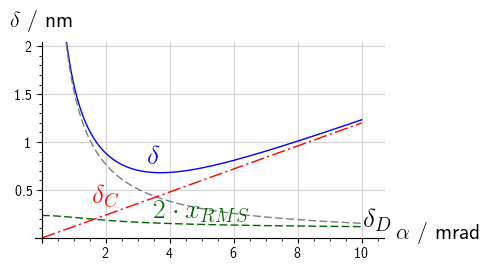

In [11]:
resCalcTM.delta_E = 20
resCalcTM.loss = 585
print('Farbfehler bei %.1f mrad: %.3f nm'% (diameter_to_angle(20*1e-6, resCalcTM.focal_length)*1e3,
                                            resCalcTM.delta_c(20*1e-6)*1e9
                                           ))
print('Auflösung bei %.1f mrad: %.3f nm' % (diameter_to_angle(20*1e-6, resCalcTM.focal_length)*1e3,
                                            resCalcTM.delta_total(20*1e-6)*1e9
                                           ))

p4 = plot(prepare_to_plot(resCalcTM.delta_total),
          (0, 10),
          ymax=2,
          axes_labels=(r'$\alpha$ / mrad', r'$\delta$ / nm')
         ) + \
    plot(prepare_to_plot(resCalcTM.delta_d), (0, 10), linestyle='--', color='grey') + \
    plot(prepare_to_plot(resCalcTM.b_rms_times2), (0, 10), linestyle='--', color='darkgreen') + \
    plot(prepare_to_plot(resCalcTM.delta_c), (0.01, 10), linestyle='-.', color='red') + \
    text("$\delta$", (3.5, 0.85), fontsize=20, color='blue') + \
    text("$2\cdot x_{RMS}$", (5, 0.25), fontsize=20, color='darkgreen') + \
    text("$\delta_D$", (10.5, 0.15), fontsize=20, color='black') + \
    text("$\delta_C$", (2, 0.4), fontsize=20, color='red')
    
p4.show(figsize=5, aspect_ratio=3)
p4.save('Bilder/delta_TM_20eV_585eV.pdf', figsize=5, aspect_ratio=3)

Farbfehler bei 5.8 mrad: 0.698 nm
Auflösung bei 5.8 mrad: 0.781 nm


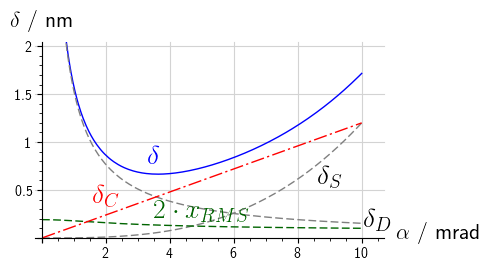

In [12]:
resCalcTM.delta_E = 20
resCalcTM.loss = 718
print('Farbfehler bei %.1f mrad: %.3f nm'% (diameter_to_angle(20*1e-6, resCalcTM.focal_length)*1e3,
                                            resCalcTM.delta_c(20*1e-6)*1e9
                                           ))
print('Auflösung bei %.1f mrad: %.3f nm' % (diameter_to_angle(20*1e-6, resCalcTM.focal_length)*1e3,
                                            resCalcTM.delta_total(20*1e-6)*1e9
                                           ))

p5 = plot(prepare_to_plot(resCalcTM.delta_total_2),
          (0, 10),
          ymax=2,
          axes_labels=(r'$\alpha$ / mrad', r'$\delta$ / nm')
         ) + \
    plot(prepare_to_plot(resCalcTM.delta_d), (0, 10), linestyle='--', color='grey') + \
    plot(prepare_to_plot(resCalcTG.delta_s), (0, 10), linestyle='--', color='grey') + \
    plot(prepare_to_plot(resCalcTM.b_rms_times2), (0, 10), linestyle='--', color='darkgreen') + \
    plot(prepare_to_plot(resCalcTM.delta_c), (0.01, 10), linestyle='-.', color='red') + \
    text("$\delta$", (3.5, 0.85), fontsize=20, color='blue') + \
    text("$\delta_S$", (9, 0.6), fontsize=20, color='black') + \
    text("$2\cdot x_{RMS}$", (5, 0.25), fontsize=20, color='darkgreen') + \
    text("$\delta_D$", (10.5, 0.15), fontsize=20, color='black') + \
    text("$\delta_C$", (2, 0.4), fontsize=20, color='red')
    
p5.show(figsize=5, aspect_ratio=3)
p5.save('Bilder/delta_TM_20eV_585eV+S.pdf', figsize=5, aspect_ratio=3)

122


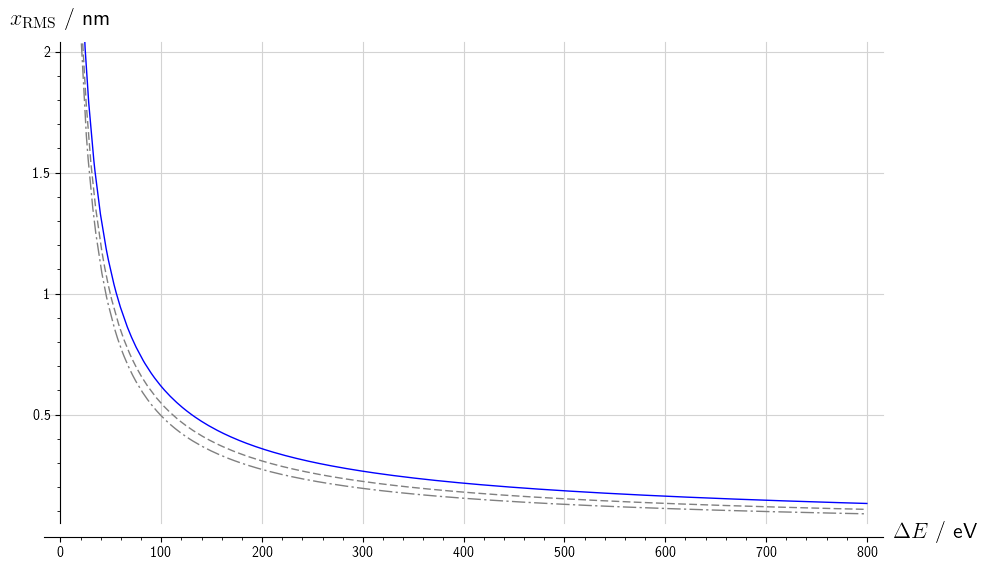

In [13]:
def prepare_to_plot2(func):
    def new_func(loss):
        return func(loss) * 1e9
    return new_func

def calc_b10(loss):
    diameter = 10e-6
    return resCalcTM.calc_b(loss, diameter)

def calc_b20(loss):
    diameter = 20e-6
    return resCalcTM.calc_b(loss, diameter)

def calc_b40(loss):
    diameter = 40e-6
    return resCalcTM.calc_b(loss, diameter)

loss_limit = 1
while calc_b10(loss_limit) > resCalcTG.delta_total(10e-6):
    loss_limit += 1

print loss_limit

p6 = plot(prepare_to_plot2(calc_b10),
          (0, 800),
          aspect_ratio=200,
          ymax=2,
          axes_labels=(r'$\Delta E$ / eV', r'$x_\mathrm{RMS}$ / nm')
         ) + \
    plot(prepare_to_plot2(calc_b20), (0, 800), linestyle='--', color='grey') + \
    plot(prepare_to_plot2(calc_b40), (0, 800), linestyle='-.', color='grey')

p6.show(figsize=10, aspect_ratio=240)
p6.save('Bilder/delta_TM_loss.pdf', figsize=10, aspect_ratio=240)